In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from tqdm import tqdm

from utils.load_data import load_split
from utils.types import FeatureMatrix_float64, FeatureVector_float32, RGBImage_uint8

In [2]:
train_images, train_labels = load_split("data/train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape

Loading FAKE images: 100%|██████████| 50000/50000 [00:24<00:00, 2005.72it/s]


(100000, (32, 32, 3), (100000,))

In [3]:
test_images, test_labels = load_split("data/test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape

Loading FAKE images: 100%|██████████| 10000/10000 [00:06<00:00, 1622.24it/s]


(20000, (32, 32, 3), (20000,))

In [4]:
train_labels[0:50000], train_labels[50000:]

(array([0, 0, 0, ..., 0, 0, 0], shape=(50000,), dtype=uint8),
 array([1, 1, 1, ..., 1, 1, 1], shape=(50000,), dtype=uint8))

In [5]:
test_labels[0:10000], test_labels[10000:]

(array([0, 0, 0, ..., 0, 0, 0], shape=(10000,), dtype=uint8),
 array([1, 1, 1, ..., 1, 1, 1], shape=(10000,), dtype=uint8))

In [6]:
def extract_lbp(img: RGBImage_uint8, p: int, r: float, method: str) -> FeatureVector_float32:
    """Extract LBP histogram from an image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp: FeatureMatrix_float64 = local_binary_pattern(gray, P=p, R=r, method=method)
    # lbp shape = (h, w)
    if method == "default":
        n_bins = 2**p
    elif method == "uniform":  # --> Each pixel has an LBP code in 0 to 9
        n_bins = p + 2  # e.g., p=8 --> 10 bins
    elif method == "nri_uniform":
        n_bins = p * (p - 1) + 3
    else:
        n_bins = int(lbp.max() + 1)

    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

In [7]:
extract_lbp(train_images[0], p=8, r=1, method="uniform").shape

(10,)

In [8]:
extract_lbp(train_images[0], p=16, r=2, method="uniform").shape

(18,)

In [9]:
LBP_P = 8  # Number of circularly symmetric neighbor set points.
LBP_R = 1  # Radius of circle.
# This create 3x3 neighborhood similar to filter masks.
LBP_METHOD = "uniform"  # Use uniform patterns.

lbp_features_list_train: list[FeatureVector_float32] = [
    extract_lbp(img, p=LBP_P, r=LBP_R, method=LBP_METHOD)
    for img in tqdm(train_images, desc="Extracting LBP features from train images")
]
lbp_features_list_test: list[FeatureVector_float32] = [
    extract_lbp(img, p=LBP_P, r=LBP_R, method=LBP_METHOD)
    for img in tqdm(test_images, desc="Extracting LBP features from test images")
]

Extracting LBP features from test images: 100%|██████████| 20000/20000 [00:02<00:00, 7244.57it/s]


In [12]:
real_lbp_hist: list[FeatureVector_float32] = np.array(lbp_features_list_train)[:50000].mean(axis=0)
fake_lbp_hist: list[FeatureVector_float32] = np.array(lbp_features_list_train)[50000:].mean(axis=0)

In [13]:
real_lbp_hist

array([0.05805133, 0.09036484, 0.06773715, 0.12630337, 0.19784588,
       0.14213535, 0.06631947, 0.06993762, 0.06620529, 0.11509969],
      dtype=float32)

In [14]:
def compare_lbp_histograms(
    hist1: FeatureVector_float32,
    hist2: FeatureVector_float32,
    labels: tuple[str, str] = ("Real", "Fake"),
    method: str = "uniform",
    p: int = 8,
) -> None:
    plt.figure(figsize=(8, 4))
    plt.plot(hist1, label=labels[0])
    plt.plot(hist2, label=labels[1])
    plt.title(f"LBP Histogram Comparison (method='{method}', P={p})")
    plt.xlabel("LBP code")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.xticks(range(len(hist1)))
    plt.show()

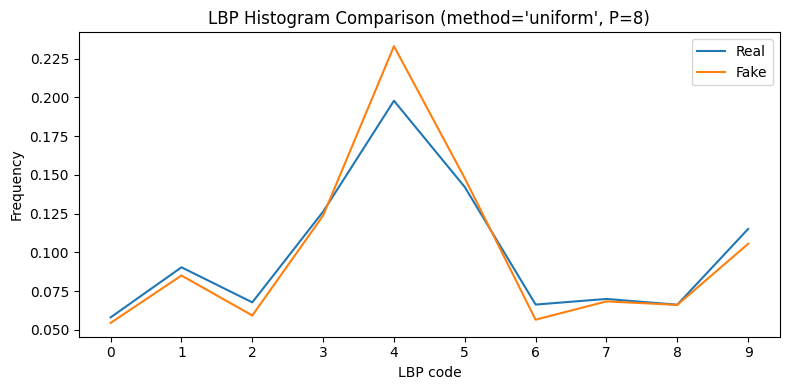

In [15]:
# example:
compare_lbp_histograms(real_lbp_hist, fake_lbp_hist, method=LBP_METHOD, p=LBP_P)


In [16]:
real_lbp_hist.sum(), fake_lbp_hist.sum()

(np.float32(1.0), np.float32(0.99999994))

In [17]:
def side_by_side_lbp(real_hist: FeatureVector_float32, fake_hist: FeatureVector_float32, method: str, p: int) -> None:
    x = np.arange(len(real_hist))

    plt.figure(figsize=(10, 4))
    plt.bar(x - 0.2, real_hist, width=0.4, label="Real")
    plt.bar(x + 0.2, fake_hist, width=0.4, label="Fake")
    plt.title(f"Side-by-Side LBP Histogram (method='{method}', P={p})")
    plt.xlabel("LBP code")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

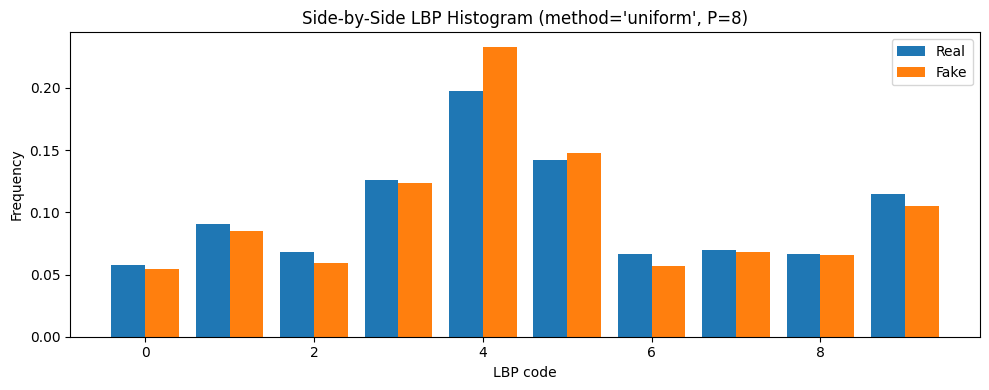

In [ ]:
side_by_side_lbp(real_lbp_hist, fake_lbp_hist, method=LBP_METHOD, p=LBP_P)

In [18]:
def compare_lbp_histograms_diff(hist1: FeatureVector_float32, hist2: FeatureVector_float32) -> None:
    diff = hist2 - hist1
    x = np.arange(len(hist1))

    plt.figure(figsize=(8, 4))
    plt.bar(x, diff, color="purple")
    plt.axhline(0, color="black", linewidth=1)
    plt.title("LBP Histogram Difference (Fake - Real)")
    plt.xlabel("LBP code")
    plt.ylabel("Difference")
    plt.tight_layout()
    plt.show()


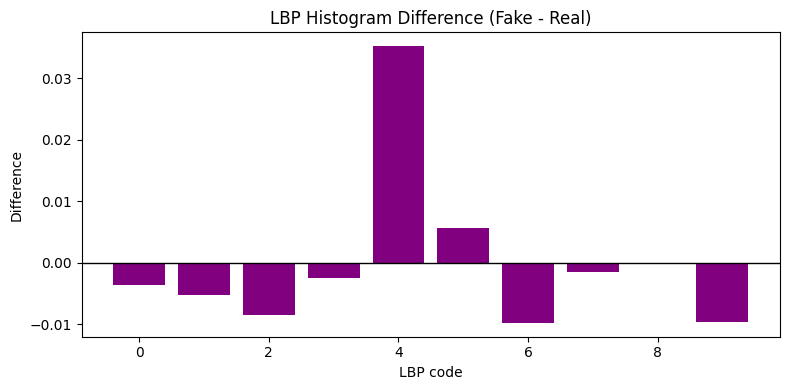

In [19]:
compare_lbp_histograms_diff(real_lbp_hist, fake_lbp_hist)

In [48]:
def plot_lbp_images(
    images: list[RGBImage_uint8],
    indices: list[int],
    p: int,
    r: float,
    method: str,
    filtered_label: int | None = None,
) -> None:
    n = len(indices)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = images[idx]
        lbp = local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), P=p, R=r, method=method)

        plt.subplot(2, n, i + 1)
        plt.imshow(img)
        plt.title(f"Image Index: {idx}")
        plt.axis("off")

        if filtered_label is not None:
            lbp = lbp == filtered_label
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(lbp, cmap="gray")
        plt.title("LBP")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

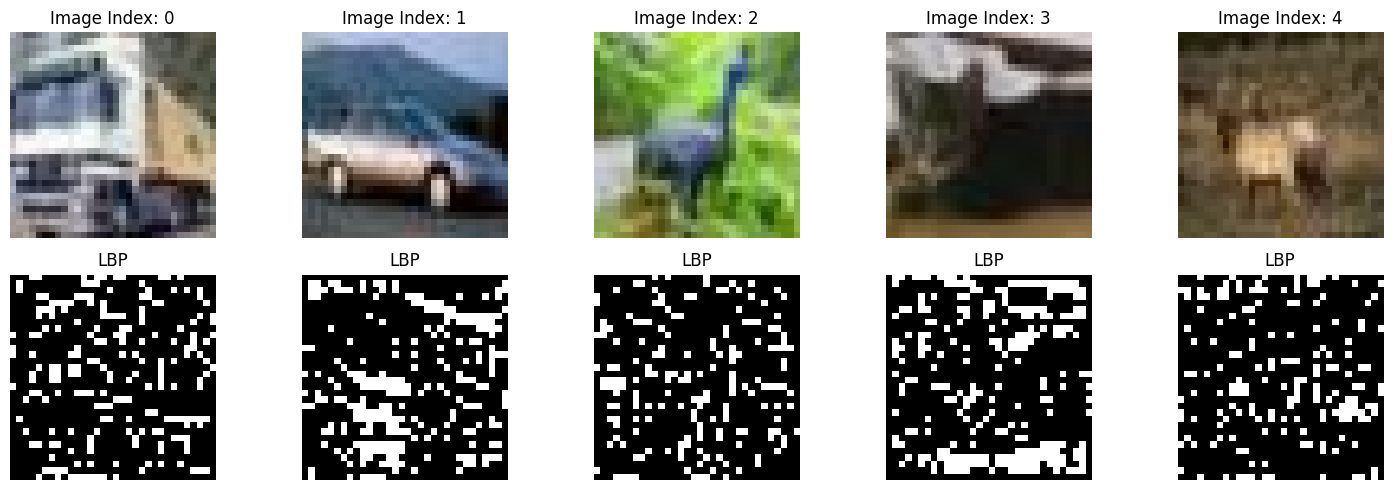

In [58]:
plot_lbp_images(
    train_images,
    indices=[0, 1, 2, 3, 4],
    p=LBP_P,
    r=LBP_R,
    method=LBP_METHOD,
    filtered_label=4,
)

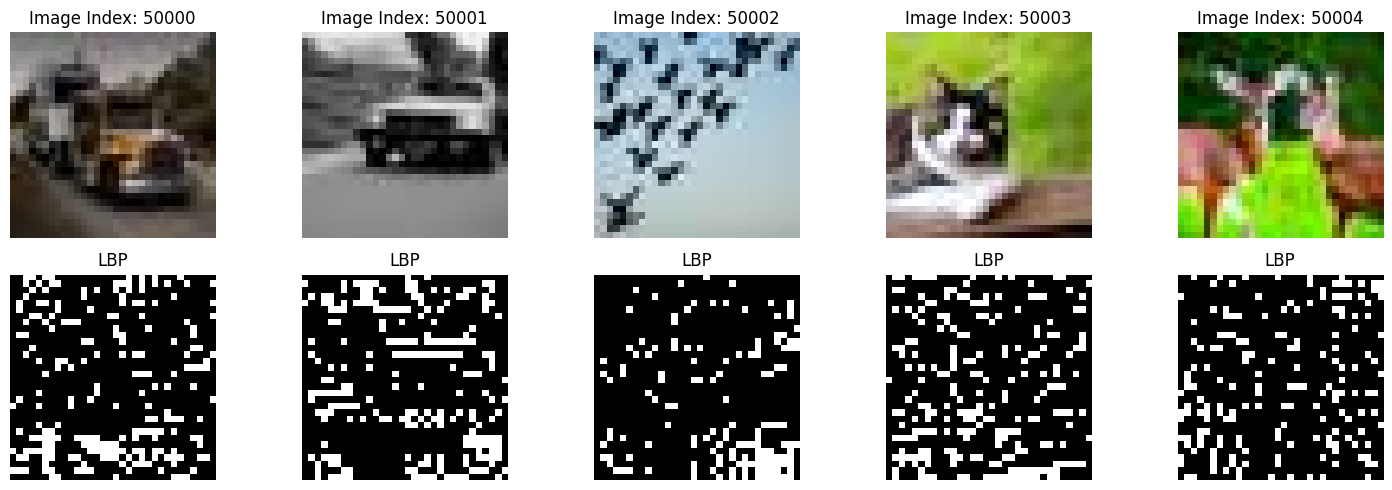

In [60]:
plot_lbp_images(
    train_images,
    indices=[50000, 50001, 50002, 50003, 50004],
    p=LBP_P,
    r=LBP_R,
    method=LBP_METHOD,
    filtered_label=4,
)

In [62]:
X_train = np.array(lbp_features_list_train)
y_train = train_labels
X_test = np.array(lbp_features_list_test)
y_test = test_labels

In [63]:
# make X_train and y_train into dataframes
import pandas as pd

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.Series(y_test)
df_train = pd.concat([X_train_df, y_train_df], axis=1)
df_test = pd.concat([X_test_df, y_test_df], axis=1)
df_train.columns = [f"LBP_{i}" for i in range(X_train.shape[1])] + ["label"]
df_test.columns = [f"LBP_{i}" for i in range(X_test.shape[1])] + ["label"]

In [64]:
df_train

,LBP_0,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,label
0,0.070312,0.095703,0.058594,0.111328,0.200195,0.151367,0.059570,0.070312,0.050781,0.131836,0
1,0.062500,0.091797,0.062500,0.105469,0.244141,0.124023,0.046875,0.073242,0.059570,0.129883,0
2,0.068359,0.095703,0.064453,0.126953,0.177734,0.144531,0.076172,0.066406,0.054688,0.125000,0
3,0.048828,0.084961,0.065430,0.096680,0.247070,0.145508,0.061523,0.075195,0.069336,0.105469,0
4,0.065430,0.103516,0.081055,0.110352,0.171875,0.118164,0.093750,0.064453,0.060547,0.130859,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.053711,0.096680,0.051758,0.131836,0.244141,0.147461,0.052734,0.069336,0.053711,0.098633,1
99996,0.041016,0.056641,0.041992,0.122070,0.276367,0.180664,0.063477,0.054688,0.068359,0.094727,1
99997,0.068359,0.113281,0.055664,0.085938,0.205078,0.113281,0.045898,0.086914,0.088867,0.136719,1
99998,0.044922,0.119141,0.058594,0.124023,0.193359,0.126953,0.064453,0.093750,0.050781,0.124023,1


In [65]:
df_test

,LBP_0,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,label
0,0.074219,0.099609,0.061523,0.117188,0.161133,0.127930,0.076172,0.076172,0.058594,0.147461,0
1,0.075195,0.092773,0.057617,0.117188,0.190430,0.128906,0.072266,0.062500,0.067383,0.135742,0
2,0.067383,0.082031,0.067383,0.130859,0.201172,0.138672,0.073242,0.068359,0.050781,0.120117,0
3,0.063477,0.105469,0.073242,0.111328,0.190430,0.112305,0.050781,0.090820,0.069336,0.132812,0
4,0.039062,0.086914,0.069336,0.161133,0.194336,0.159180,0.078125,0.071289,0.049805,0.090820,0
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.069336,0.099609,0.061523,0.100586,0.199219,0.133789,0.052734,0.083008,0.061523,0.138672,1
19996,0.078125,0.111328,0.055664,0.109375,0.181641,0.109375,0.060547,0.085938,0.074219,0.133789,1
19997,0.062500,0.076172,0.083984,0.127930,0.237305,0.129883,0.055664,0.067383,0.055664,0.103516,1
19998,0.043945,0.094727,0.071289,0.106445,0.246094,0.154297,0.056641,0.083984,0.045898,0.096680,1


In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   LBP_0   100000 non-null  float32
 1   LBP_1   100000 non-null  float32
 2   LBP_2   100000 non-null  float32
 3   LBP_3   100000 non-null  float32
 4   LBP_4   100000 non-null  float32
 5   LBP_5   100000 non-null  float32
 6   LBP_6   100000 non-null  float32
 7   LBP_7   100000 non-null  float32
 8   LBP_8   100000 non-null  float32
 9   LBP_9   100000 non-null  float32
 10  label   100000 non-null  uint8  
dtypes: float32(10), uint8(1)
memory usage: 3.9 MB


In [67]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LBP_0   20000 non-null  float32
 1   LBP_1   20000 non-null  float32
 2   LBP_2   20000 non-null  float32
 3   LBP_3   20000 non-null  float32
 4   LBP_4   20000 non-null  float32
 5   LBP_5   20000 non-null  float32
 6   LBP_6   20000 non-null  float32
 7   LBP_7   20000 non-null  float32
 8   LBP_8   20000 non-null  float32
 9   LBP_9   20000 non-null  float32
 10  label   20000 non-null  uint8  
dtypes: float32(10), uint8(1)
memory usage: 800.9 KB


In [40]:
df_train.to_csv("data/lbp_features_train.csv", index=False)
df_test.to_csv("data/lbp_features_test.csv", index=False)